In [2]:
import pandas as pd

df_train = pd.read_csv("data/sign_mnist_train.csv")
df_test = pd.read_csv("data/sign_mnist_test.csv")

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (27455, 785)
Test shape: (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from PIL import Image

class SignLanguageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data['label'].values
        self.images = self.data.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [14]:
# Image transform: converts PIL to Tensor + normalises
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # random rotation ±10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # random offset by 10%
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = SignLanguageDataset("data/sign_mnist_train/sign_mnist_train.csv", transform=train_transform)
test_dataset = SignLanguageDataset("data/sign_mnist_test/sign_mnist_test.csv", transform=train_transform)

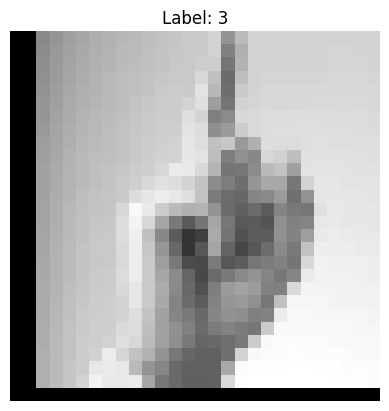

In [15]:
import matplotlib.pyplot as plt

img, label = train_dataset[0]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [16]:
from torch.utils.data import DataLoader

In [17]:
# Set batch size
batch_size = 64

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Take one batch to inspect
images, labels = next(iter(train_loader))

print("Batch shape (images):", images.shape)   # [64, 1, 28, 28]
print("Batch shape (labels):", labels.shape)   # [64]

Batch shape (images): torch.Size([64, 1, 28, 28])
Batch shape (labels): torch.Size([64])


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class LinearNN(nn.Module):
    def __init__(self):
        super(LinearNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)    # Input: 784 to Hidden: 256
        self.fc2 = nn.Linear(256, 128)      # Hidden: 256 to 128
        self.dropout = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 25)       # Output: 128 to 25 classes (A–Y excluding J)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LinearNN().to(device)

In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [22]:
import copy
import time

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10, patience=5):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    best_loss = float('inf')
    patience_counter = 0
    best_model_state = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct_test, total_test = 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"Test loss: {test_loss:.4f}, acc: {test_acc:.4f} | "
              f"Time: {time.time() - start_time:.1f}s")

        # Early Stopping
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(best_model_state)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
EPOCHS = 20
train_losses, test_losses, train_accs, test_accs = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer,
    epochs=EPOCHS, patience=5
)

Epoch 1/20 - Train loss: 2.0035, acc: 0.3703 | Test loss: 1.4808, acc: 0.5184 | Time: 4.7s
Epoch 2/20 - Train loss: 1.2890, acc: 0.5743 | Test loss: 1.1441, acc: 0.6273 | Time: 4.5s
Epoch 3/20 - Train loss: 1.0579, acc: 0.6487 | Test loss: 0.9614, acc: 0.6772 | Time: 4.5s
Epoch 4/20 - Train loss: 0.9339, acc: 0.6840 | Test loss: 0.9032, acc: 0.6944 | Time: 4.5s
Epoch 5/20 - Train loss: 0.8421, acc: 0.7186 | Test loss: 0.8326, acc: 0.7192 | Time: 4.4s
Epoch 6/20 - Train loss: 0.7823, acc: 0.7414 | Test loss: 0.7507, acc: 0.7567 | Time: 4.9s
Epoch 7/20 - Train loss: 0.7365, acc: 0.7507 | Test loss: 0.7487, acc: 0.7566 | Time: 4.5s
Epoch 8/20 - Train loss: 0.7099, acc: 0.7626 | Test loss: 0.6940, acc: 0.7667 | Time: 4.4s
Epoch 9/20 - Train loss: 0.6613, acc: 0.7772 | Test loss: 0.6836, acc: 0.7665 | Time: 4.6s
Epoch 10/20 - Train loss: 0.6456, acc: 0.7855 | Test loss: 0.6652, acc: 0.7796 | Time: 4.5s
Epoch 11/20 - Train loss: 0.6234, acc: 0.7922 | Test loss: 0.6435, acc: 0.7853 | Time: 4.

In [25]:
EPOCHS = 50
train_losses, test_losses, train_accs, test_accs = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer,
    epochs=EPOCHS, patience=5
)

Epoch 1/50 - Train loss: 0.5193, acc: 0.8290 | Test loss: 0.5220, acc: 0.8305 | Time: 4.6s
Epoch 2/50 - Train loss: 0.5128, acc: 0.8269 | Test loss: 0.5010, acc: 0.8328 | Time: 4.7s
Epoch 3/50 - Train loss: 0.5011, acc: 0.8336 | Test loss: 0.5196, acc: 0.8338 | Time: 4.7s
Epoch 4/50 - Train loss: 0.5001, acc: 0.8332 | Test loss: 0.5215, acc: 0.8271 | Time: 4.7s
Epoch 5/50 - Train loss: 0.5045, acc: 0.8304 | Test loss: 0.4840, acc: 0.8458 | Time: 4.7s
Epoch 6/50 - Train loss: 0.5005, acc: 0.8333 | Test loss: 0.4945, acc: 0.8447 | Time: 4.8s
Epoch 7/50 - Train loss: 0.4926, acc: 0.8362 | Test loss: 0.5045, acc: 0.8335 | Time: 4.7s
Epoch 8/50 - Train loss: 0.4834, acc: 0.8358 | Test loss: 0.4996, acc: 0.8413 | Time: 4.7s
Epoch 9/50 - Train loss: 0.4801, acc: 0.8409 | Test loss: 0.5351, acc: 0.8281 | Time: 4.7s
Epoch 10/50 - Train loss: 0.4848, acc: 0.8384 | Test loss: 0.4632, acc: 0.8546 | Time: 5.0s
Epoch 11/50 - Train loss: 0.4860, acc: 0.8392 | Test loss: 0.4905, acc: 0.8394 | Time: 4.

In [26]:
torch.save(model.state_dict(), "fmodel_15.pth")
print("Model saved")

Model saved


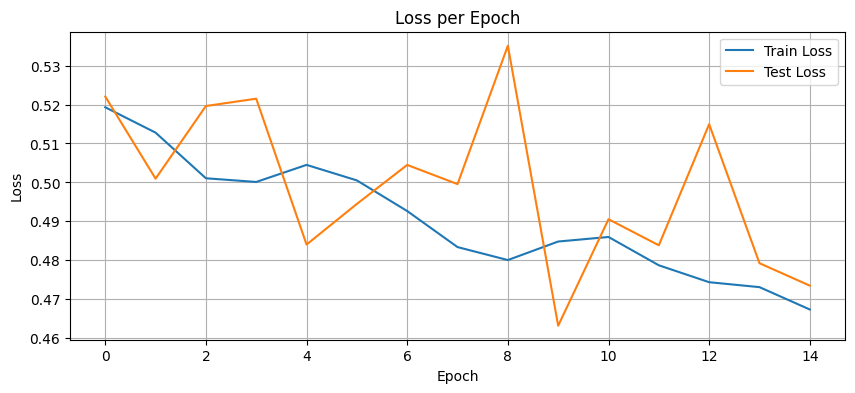

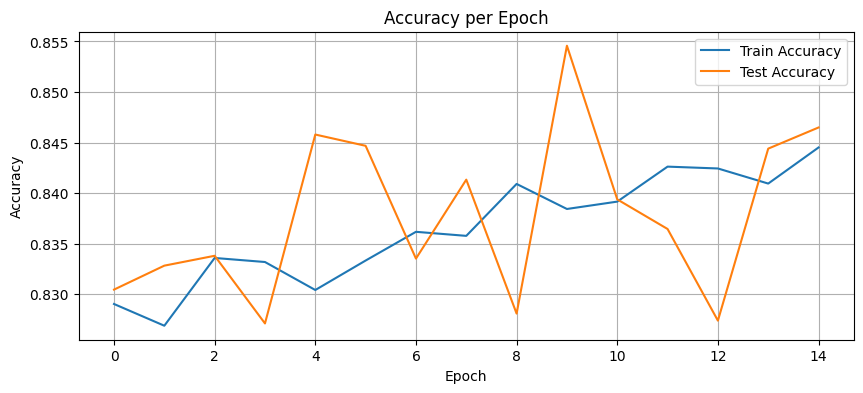

In [ ]:
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define class labels (A–Y, without J)
classes = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
    'T', 'U', 'V', 'W', 'X', 'Y', 'Z'
]

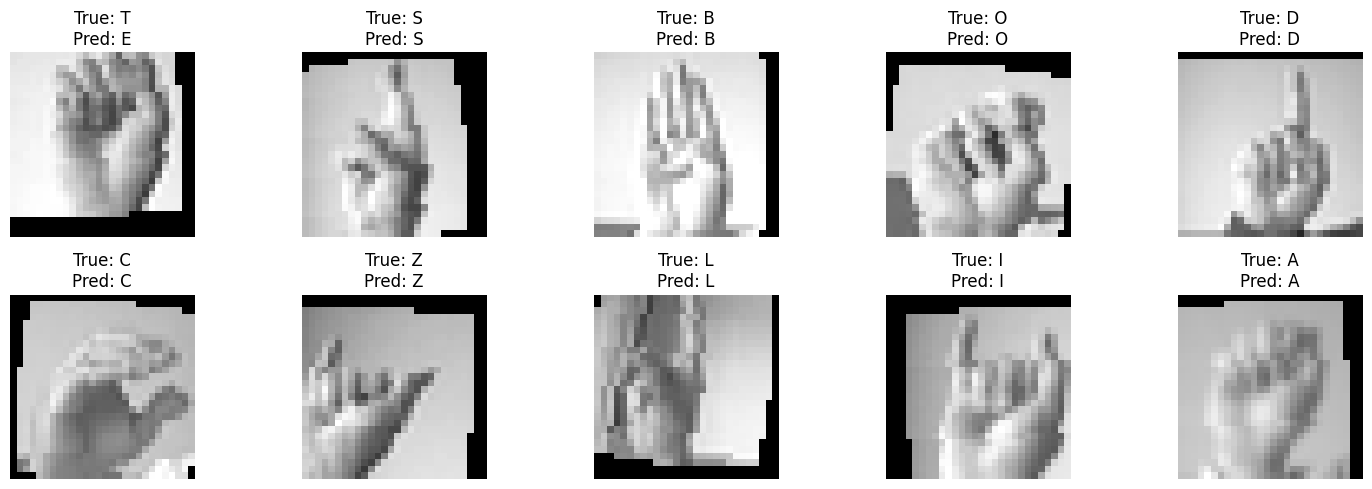

In [31]:
import random
from collections import defaultdict

# Get list of indices for each class
label_to_indices = defaultdict(list)
for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    label_to_indices[label].append(idx)

# Select one random example from 10 different classes
selected_labels = random.sample(list(label_to_indices.keys()), 10)
unique_samples = []

for label in selected_labels:
    idx = random.choice(label_to_indices[label])
    img, _ = test_dataset[idx]
    unique_samples.append((img, label))

# Visualization
plt.figure(figsize=(15, 5))

for i, (img, true_label) in enumerate(unique_samples):
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        predicted = output.argmax(1).item()

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True: {classes[true_label]}\nPred: {classes[predicted]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

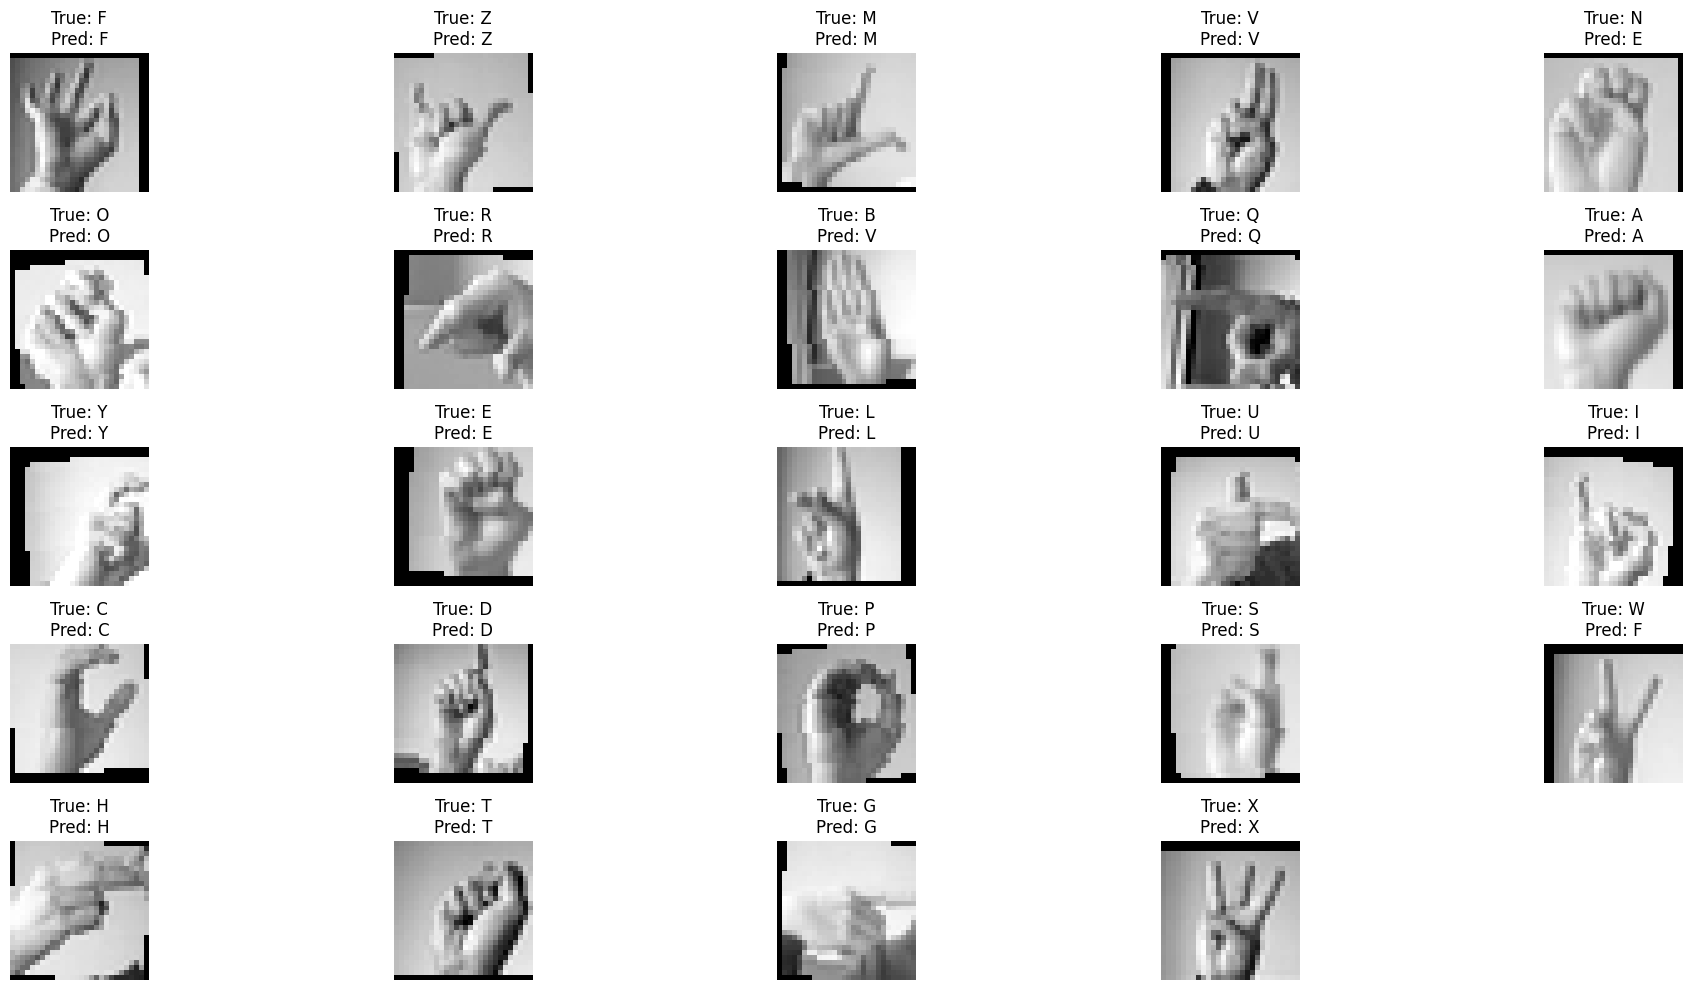

In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

# Group indices of images by their label/class
label_to_indices = defaultdict(list)
for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    label_to_indices[label].append(idx)

# Determine number of classes and select up to 25 random classes to display
num_classes = len(label_to_indices.keys())
selected_labels = random.sample(list(label_to_indices.keys()), min(25, num_classes))

# For each selected class, pick one random image
unique_samples = []
for label in selected_labels:
    idx = random.choice(label_to_indices[label])
    img, _ = test_dataset[idx]
    unique_samples.append((img, label))

# Prepare the figure with a 5x5 grid for visualization
plt.figure(figsize=(20, 10))

# Loop over selected images to display them with true and predicted labels
for i, (img, true_label) in enumerate(unique_samples):
    with torch.no_grad():
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        predicted = output.argmax(1).item()
     
    # Plot each image with title showing true and predicted classes
    plt.subplot(5, 5, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"True: {classes[true_label]}\nPred: {classes[predicted]}")
    plt.axis("off")

plt.tight_layout()
plt.show()